### Subtract background from PostISRCCD Example

In [1]:
import lsst.daf.persistence as dafPersist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
butlerNoInterp = dafPersist.Butler("/datasets/hsc/repo/rerun/private/czw/DM-17471/noInterp.20190328")
butler = dafPersist.Butler("/datasets/hsc/repo/rerun/private/czw/DM-17471/yesInterp.20190328")

In [2]:
# Get data products
dataId = {"visit": 902900, "ccd": 16}
calexp = butler.get('calexp', dataId=dataId)
background = butler.get('calexpBackground', dataId=dataId)
preInterpExp = butlerNoInterp.get('postISRCCD', dataId=dataId)

In [3]:
# Subtract the good background from the preInterExposure
mi = preInterpExp.maskedImage
mi -= background.getImage()

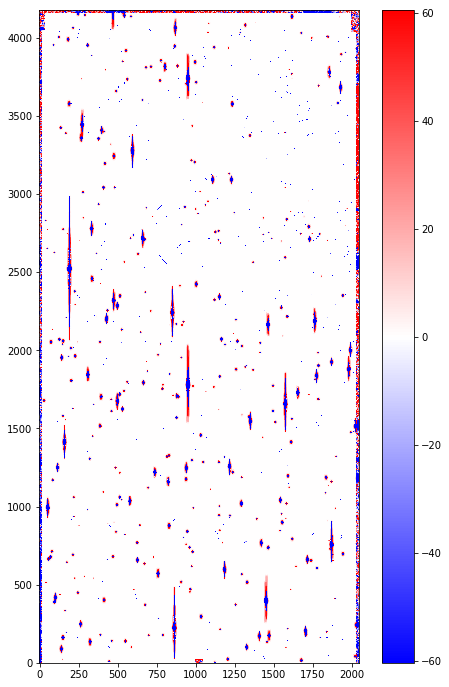

In [4]:
# Just plotting
fig = plt.figure(figsize=(8,12))
arr = calexp.image.getArray() - preInterpExp.image.getArray()
vmin, vmax = np.percentile(arr, (1, 99))
spread = min(np.abs(vmin), np.abs(vmax))
plt.imshow(arr, origin='lower', vmin=-spread, vmax=spread, cmap="bwr")
plt.colorbar()

In [5]:
# Write the diff as fits. This modifies `preInterpExp`

# mi -= calexp.getMaskedImage()
# preInterpExp.writeFits('diff.fits')

### Replace interpolated pixels in the calexp

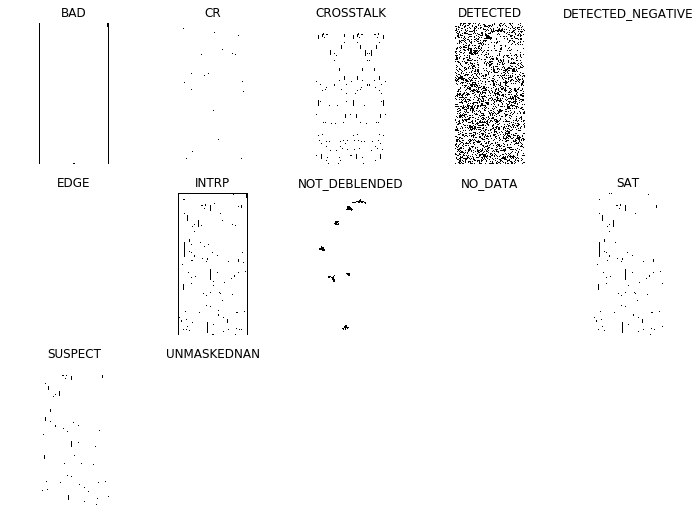

In [6]:
# Just plotting
mask = calexp.mask
fig = plt.figure(figsize=(12,12))
for i, (name, bit) in enumerate(mask.getMaskPlaneDict().items()):
    fig.add_subplot(4, 5, i + 1)
    arr = np.where(mask.array & 2**bit, 1, 0)
    plt.imshow(arr, origin='lower', cmap='Greys', interpolation='nearest')
    plt.title(name)
    plt.axis('off')

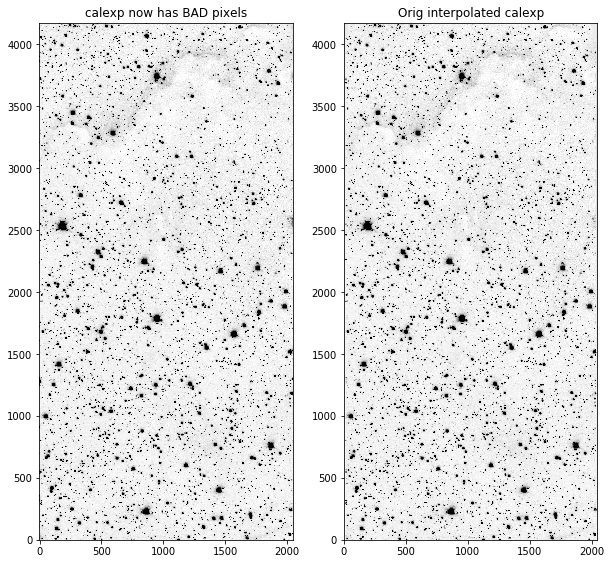

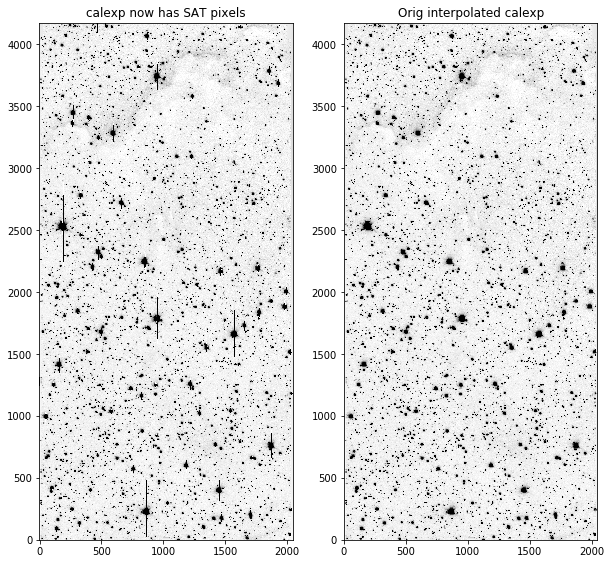

In [7]:
# Just plotting
vmin, vmax = np.percentile(calexp.image.array, (2, 97))
for PLANE in ["BAD", "SAT"]:
    bit = calexp.mask.getMaskPlaneDict()[PLANE]
    imArr = np.where(calexp.mask.array & 2**bit, preInterpExp.image.array, calexp.image.array)
    fig = plt.figure(figsize=(10, 20))
    plt.subplot(121)
    plt.title("calexp now has %s pixels" % (PLANE))
    plt.imshow(imArr, origin='lower', vmin=vmin, vmax=vmax, cmap="Greys")
    plt.subplot(122)
    plt.title("Orig interpolated calexp")
    plt.imshow(calexp.image.array, origin='lower', vmin=vmin, vmax=vmax, cmap="Greys")
    plt.show()

In [9]:
PLANES_INTERPOLATED = ["BAD", "SAT", "CR"]

##############################
# Say we want to replace only the SAT and the BAD Pixels:
PLANE = ["SAT", "BAD"]
#############################
# Replace this with the following if you want to replace only one plane 
#PLANE = ['SAT',] 

bitValue = calexp.mask.getPlaneBitMask(PLANE)

imArr = np.where(calexp.mask.array & bitValue, preInterpExp.image.array, calexp.image.array)

# Make a copy
calexpPreInterp = calexp.clone()

# Replace the image plane
calexpPreInterp.image.array = imArr

# Unset the INTRP plane where not  interpolated for another reason
PLANES_TO_KEEP = set(PLANES_INTERPOLATED) - set(PLANE)
bitmask = calexpPreInterp.mask.getPlaneBitMask(PLANE)
bitmaskKeep = calexpPreInterp.mask.getPlaneBitMask(list(PLANES_TO_KEEP))

replace = (calexpPreInterp.mask.array & bitmask) > 0 
keep = (calexpPreInterp.mask.array & bitmaskKeep) > 0 
interpolated = (calexpPreInterp.mask.array & calexpPreInterp.mask.getPlaneBitMask("INTRP")) > 0

idx = np.where(replace & ~keep & interpolated)
calexpPreInterp.mask.array[idx] &= ~calexpPreInterp.mask.getPlaneBitMask("INTRP")

In [ ]:
# Save to disk in the no interp repo:
butlerNoInterp.put(calexpPreInterp, "calexp", dataId)
# calexpPreInterp.writeFits("/home/yusra/calexp.fits")

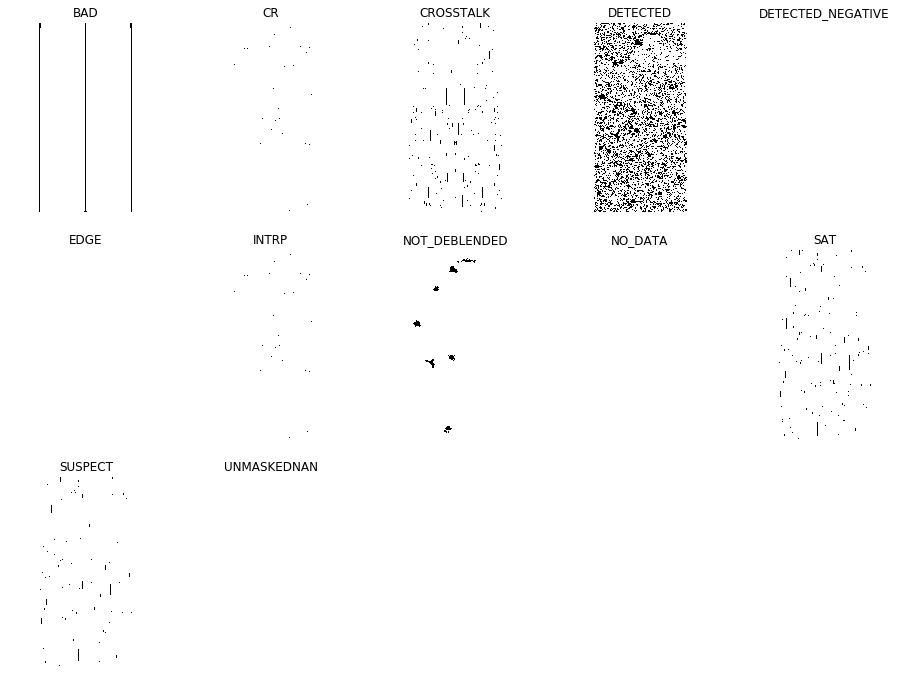

In [11]:
# Just plotting
mask = calexpPreInterp.mask
fig = plt.figure(figsize=(16,16))
for i, (name, bit) in enumerate(mask.getMaskPlaneDict().items()):
    fig.add_subplot(4, 5, i + 1)
    arr = np.where(mask.array & 2**bit, 1, 0)
    plt.imshow(arr, origin='lower', cmap='Greys', interpolation='nearest')
    plt.title(name)
    plt.axis('off')